Compare clustering between homology and morphometrics

In [1]:
import os
import time
import imagej
import numpy as np
import gudhi as gd
from gudhi.representations.metrics import BottleneckDistance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward, complete
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Initialize Fiji with GUI support.
ij = imagej.init(r'C:\Users\cam\Desktop\My_Desktop\Fiji.app', headless=False)
from jnius import autoclass, cast

In [3]:
Context = autoclass('org.scijava.Context')
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
TreeAnalyzer = autoclass('sc.fiji.snt.analysis.TreeAnalyzer')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')
MultiTreeColorMapper = autoclass('sc.fiji.snt.analysis.MultiTreeColorMapper')
ColorTables = autoclass('net.imagej.display.ColorTables')

In [4]:
tree_map = {}     # global
diagram_map = {}
labels = []       # global

In [5]:
def fetch_reconstructions():
    # Two types of mouse PT neuron from MOs with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # Group 0 contains the Medulla projecting sub-type. 
    # Group 1 contains the Thalamic projecting sub-type.
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group_0 = ['AA1043', 'AA0882', 'AA0169', 'AA0134', 'AA0133']
    group_1 = ['AA0927', 'AA0772', 'AA0726', 'AA0617', 'AA0261', 'AA0245', 'AA0181', 'AA0122', 'AA0011']
    groups = [group_0, group_1]
    trees = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return
            # Only compare axon topologies
            tree = loader.getTree('axon')
            trees.append(tree)
            tree_map[tree.getLabel()[0:6]] = tree
            tree.setLabel(tree.getLabel().replace('.swc', '') + ' group: ' + str(num))
            labels.append(tree.getLabel())
            
    return trees
    
    
def compute_homology(trees):
    diagrams = []
    for tree in trees:  
        # Obtain Persistence Diagram as an nx2 array where each row corresponds
        # to one birth-death interval.
        diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram('radial')))
        diagrams.append(diagram)
        diagram_map[tree.getLabel()[0:6]] = diagram
        # necessary to pass a 2D numeric array to sklearn.metrics.pairwise_distances
    t0 = time.time()
    bd = BottleneckDistance(epsilon=None)
    # symmetric distance matrix
    matrix = bd.fit_transform(diagrams)
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return matrix


def compute_morphometrics(trees):
    matrix = []
    metrics = ij.py.from_java(TreeAnalyzer.getMetrics())
    for tree in trees:
        an = TreeAnalyzer(tree)
        vec = []
        for m in metrics:
            result = float(ij.py.from_java(an.getMetric(m)))
            vec.append(result)
        matrix.append(vec)
        
    # matrix with shape (n_cells * n_features)
    return np.asarray(matrix)


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', labels=labels) 

In [6]:
trees = fetch_reconstructions()

In [7]:
# Get bottleneck distance matrix
bd_matrix = compute_homology(trees)

0.3402998447418213  seconds to compute all distances


In [8]:
# Get morphometrics data matrix
morph_matrix = compute_morphometrics(trees)
# standardize since measured quantities are different
scaled_morph_matrix = StandardScaler().fit_transform(morph_matrix)

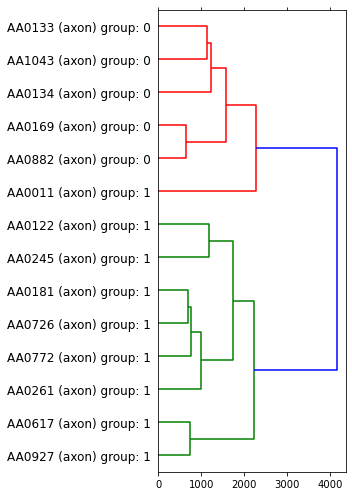

In [9]:
# Perform Hierarchical Clustering on the bottleneck distance matrix and plot a dendrogram
# of the resulting linkage matrix

# convert to n-choose-2 dimensional vector to pass to linkage function
mat_arr = squareform(bd_matrix)
linkage_matrix = complete(mat_arr) # use complete linkage

fig, ax = plt.subplots(figsize=(5, 7)) # set size
dendrogram(linkage_matrix, orientation='right', labels=labels) 
plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout()
#plt.savefig('ward_clusters.png', dpi=200)

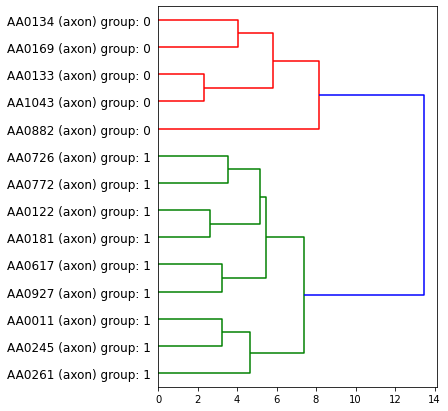

In [10]:
# cluster using morphometrics, we use the Agglomerative clustering function 
# since the input is an array of feature vectors instead of a distance matrix
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
model = model.fit(scaled_morph_matrix)
fig, ax = plt.subplots(figsize=(5,7))
plot_dendrogram(model)

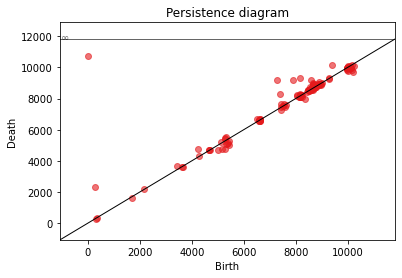

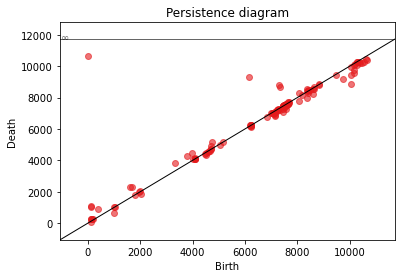

In [11]:
# convert diagrams to required format for gudhi plotter
# (dimension, (birth, death))
for key, pd in diagram_map.items():
    d = []
    for p in pd:
        d.append((0,(p[0], p[1])))
    diagram_map[key] = d
gd.plot_persistence_diagram(diagram_map['AA0133'])
gd.plot_persistence_diagram(diagram_map['AA1043'])